In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import numpy as np

# Load dataset
df_new = pd.read_csv("/Users/raghav/Documents/GitHub/ACSEF/ACSEFFinal.csv")

# Convert categorical columns to numerical values
categorical_cols = ['gender', 'race', 'tissue_or_organ_of_origin', 'tumor_grade', 'treatment_type']
for col in categorical_cols:
    if col in df_new.columns:
        le = LabelEncoder()
        df_new[col] = le.fit_transform(df_new[col].astype(str))

# Convert target variable (MostVariableGene) into numerical labels
le_target = LabelEncoder()
df_new['MostVariableGene'] = le_target.fit_transform(df_new['MostVariableGene'].astype(str))

# Drop rows with missing target variable
df_new = df_new.dropna(subset=['MostVariableGene'])

# Feature Engineering: Log transform file_size to reduce skew
if 'file_size' in df_new.columns:
    df_new['file_size'] = np.log1p(df_new['file_size'])

# Interaction Features
df_new['grade_treatment'] = df_new['tumor_grade'] * df_new['treatment_type']
df_new['race_origin'] = df_new['race'] * df_new['tissue_or_organ_of_origin']

# Polynomial Features for Key Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df_new[['file_size', 'tumor_grade', 'treatment_type']])
poly_feature_names = poly.get_feature_names_out(['file_size', 'tumor_grade', 'treatment_type'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
df_new = pd.concat([df_new, poly_df], axis=1)

# Feature Selection: Keep only the most important features
selected_features = ['file_size', 'treatment_type', 'tumor_grade', 'tissue_or_organ_of_origin', 'race', 'gender', 'grade_treatment', 'race_origin'] + list(poly_feature_names)
X = df_new[selected_features]
y = pd.Series(df_new['MostVariableGene'])  # Ensure y remains a Pandas Series

# Remove classes with fewer than 2 samples
class_counts = y.value_counts()
valid_classes = class_counts[class_counts > 1].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

# Re-encode target variable after filtering
y = pd.Series(LabelEncoder().fit_transform(y))  # Ensure y remains a Pandas Series

# Handle missing values with median imputation
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X[numeric_cols]

# Drop columns that are entirely NaN before imputation
X_numeric = X_numeric.dropna(axis=1, how='all')

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed_values = imputer.fit_transform(X_numeric)
X_imputed = pd.DataFrame(X_imputed_values, columns=X_numeric.columns, index=X_numeric.index)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=X_imputed.columns, index=X_imputed.index)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust component count based on variance retained
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca)

# Handle class imbalance with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Define XGBoost model with balanced class weights
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', class_weight='balanced', early_stopping_rounds=10)

# Perform hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = RandomizedSearchCV(xgb, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, n_iter=30, random_state=42)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Train best model
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Display results
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", classification_rep)

# Save results
results_text = f"""
Model Performance Metrics:

Best Parameters: {grid_search.best_params_}
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}

Classification Report:
{classification_rep}
"""

results_file_path = "ml_results.txt"
with open(results_file_path, "w") as file:
    file.write(results_text)

print("Results saved to", results_file_path)


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4

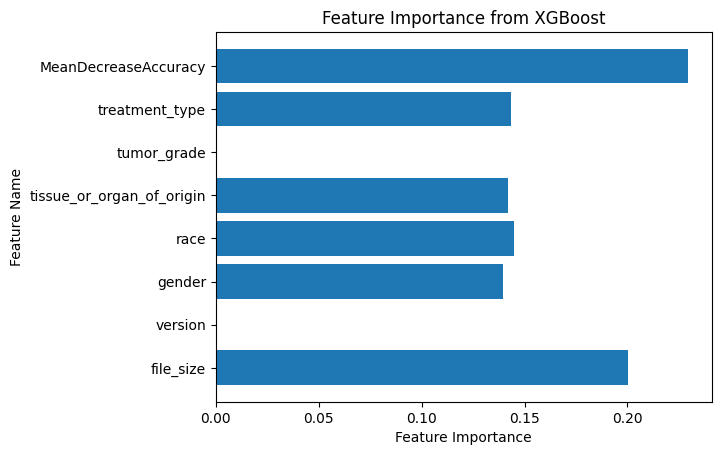

In [42]:
import matplotlib.pyplot as plt
import xgboost as xgb

feature_importance = best_model.feature_importances_
plt.barh(X_train.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance from XGBoost")
plt.show()


In [25]:

print(df_new['MostVariableGene'].isnull().sum())  # Check missing values
print(df_new.shape)  


0
(0, 69)


In [33]:
print(y.value_counts(normalize=True))


MostVariableGene
25    0.358333
20    0.126667
1     0.113333
23    0.080000
18    0.046667
15    0.043333
11    0.036667
12    0.036667
28    0.033333
22    0.028333
0     0.021667
24    0.015000
3     0.013333
9     0.010000
7     0.006667
17    0.005000
16    0.003333
19    0.003333
13    0.001667
21    0.001667
26    0.001667
2     0.001667
5     0.001667
8     0.001667
6     0.001667
10    0.001667
4     0.001667
27    0.001667
14    0.001667
Name: proportion, dtype: float64
